CODE BLOCK: 1

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [14]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if cuda else "cpu") #added this
device

CUDA Available? True


device(type='cuda')

CODE BLOCK: 3

In [15]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1407,), (0.4081,))
    transforms.Normalize((0.1307,), (0.3081,)) #both training and test data should've same
    ])

CODE BLOCK: 4

In [16]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, transform=test_transforms)  #changed this

In [17]:
# print('this is train_data', train_data)

CODE BLOCK: 5

In [18]:
batch_size = 1024 #i believe batch_size should be changed

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}  #changed this, shuffle should be True.

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)#changed this
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

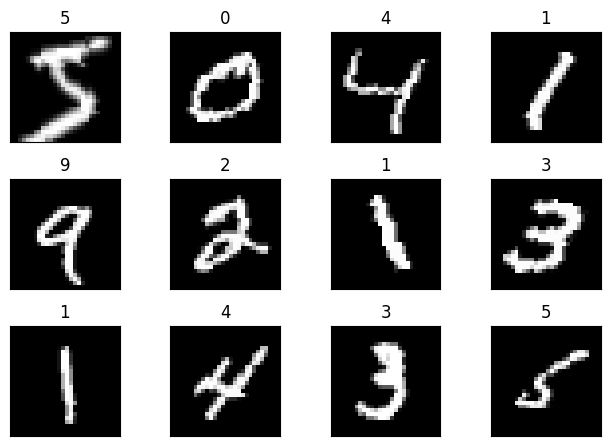

In [19]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12): #if you've set shuffle = False, then every time u run this cell, u'll get same output.
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [20]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3) #(in_channels, out_channels)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        # self.fc1 = nn.Linear(320, 50)#changing 320 to 256
        self.fc1 = nn.Linear(4096, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x), 2)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(self.conv3(x), 2)
        x = F.relu(F.max_pool2d(self.conv4(x), 2))
        # print('this is shape of x: ', x.shape)  #torch.Size([512, 256, 4, 4])
        x = x.view(-1, 4096) # 256 * 4 * 4 = 4096
        # x = F.relu(self.fc1(x)) #i believe this relu fun needs to be removed
        x = self.fc1(x)
        x = self.fc2(x)
        # print('this is final shape: ', x.shape) #(512, 10)
        return F.log_softmax(x, dim=1)

CODE BLOCK: 8

In [21]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [22]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss #changed this
            #removed parameter : reduction = 'sum' above

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [26]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) #changed lr here, most important change
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion) #changed this
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.6656 Batch_id=58 Accuracy=45.14: 100%|██████████| 59/59 [00:19<00:00,  2.96it/s]


Test set: Average loss: 0.0006, Accuracy: 7891/10000 (78.91%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.2501 Batch_id=58 Accuracy=87.29: 100%|██████████| 59/59 [00:20<00:00,  2.93it/s]


Test set: Average loss: 0.0002, Accuracy: 9539/10000 (95.39%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.1869 Batch_id=58 Accuracy=94.13: 100%|██████████| 59/59 [00:21<00:00,  2.72it/s]


Test set: Average loss: 0.0001, Accuracy: 9688/10000 (96.88%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.1698 Batch_id=58 Accuracy=95.88: 100%|██████████| 59/59 [00:20<00:00,  2.91it/s]


Test set: Average loss: 0.0001, Accuracy: 9773/10000 (97.73%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.1673 Batch_id=58 Accuracy=96.52: 100%|██████████| 59/59 [00:20<00:00,  2.88it/s]


Test set: Average loss: 0.0001, Accuracy: 9817/10000 (98.17%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.1525 Batch_id=58 Accuracy=97.00: 100%|██████████| 59/59 [00:21<00:00,  2.76it/s]


Test set: Average loss: 0.0001, Accuracy: 9832/10000 (98.32%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.1400 Batch_id=58 Accuracy=97.26: 100%|██████████| 59/59 [00:20<00:00,  2.91it/s]


Test set: Average loss: 0.0000, Accuracy: 9851/10000 (98.51%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.1015 Batch_id=58 Accuracy=97.37: 100%|██████████| 59/59 [00:21<00:00,  2.77it/s]


Test set: Average loss: 0.0000, Accuracy: 9853/10000 (98.53%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.1239 Batch_id=58 Accuracy=97.63: 100%|██████████| 59/59 [00:22<00:00,  2.66it/s]


Test set: Average loss: 0.0000, Accuracy: 9868/10000 (98.68%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.1124 Batch_id=58 Accuracy=97.84: 100%|██████████| 59/59 [00:20<00:00,  2.91it/s]


Test set: Average loss: 0.0000, Accuracy: 9877/10000 (98.77%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0905 Batch_id=58 Accuracy=98.03: 100%|██████████| 59/59 [00:20<00:00,  2.81it/s]


Test set: Average loss: 0.0000, Accuracy: 9872/10000 (98.72%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0913 Batch_id=58 Accuracy=98.08: 100%|██████████| 59/59 [00:21<00:00,  2.78it/s]


Test set: Average loss: 0.0000, Accuracy: 9879/10000 (98.79%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0804 Batch_id=58 Accuracy=98.32: 100%|██████████| 59/59 [00:20<00:00,  2.92it/s]


Test set: Average loss: 0.0000, Accuracy: 9892/10000 (98.92%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0849 Batch_id=58 Accuracy=98.33: 100%|██████████| 59/59 [00:21<00:00,  2.78it/s]


Test set: Average loss: 0.0000, Accuracy: 9905/10000 (99.05%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0738 Batch_id=58 Accuracy=98.37: 100%|██████████| 59/59 [00:21<00:00,  2.81it/s]


Test set: Average loss: 0.0000, Accuracy: 9899/10000 (98.99%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0814 Batch_id=58 Accuracy=98.58: 100%|██████████| 59/59 [00:20<00:00,  2.92it/s]


Test set: Average loss: 0.0000, Accuracy: 9919/10000 (99.19%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0688 Batch_id=58 Accuracy=98.64: 100%|██████████| 59/59 [00:21<00:00,  2.76it/s]


Test set: Average loss: 0.0000, Accuracy: 9918/10000 (99.18%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0828 Batch_id=58 Accuracy=98.69: 100%|██████████| 59/59 [00:20<00:00,  2.86it/s]


Test set: Average loss: 0.0000, Accuracy: 9920/10000 (99.20%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0645 Batch_id=58 Accuracy=98.69: 100%|██████████| 59/59 [00:20<00:00,  2.92it/s]


Test set: Average loss: 0.0000, Accuracy: 9918/10000 (99.18%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0808 Batch_id=58 Accuracy=98.63: 100%|██████████| 59/59 [00:21<00:00,  2.70it/s]


Test set: Average loss: 0.0000, Accuracy: 9919/10000 (99.19%)

Adjusting learning rate of group 0 to 1.0000e-03.


CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

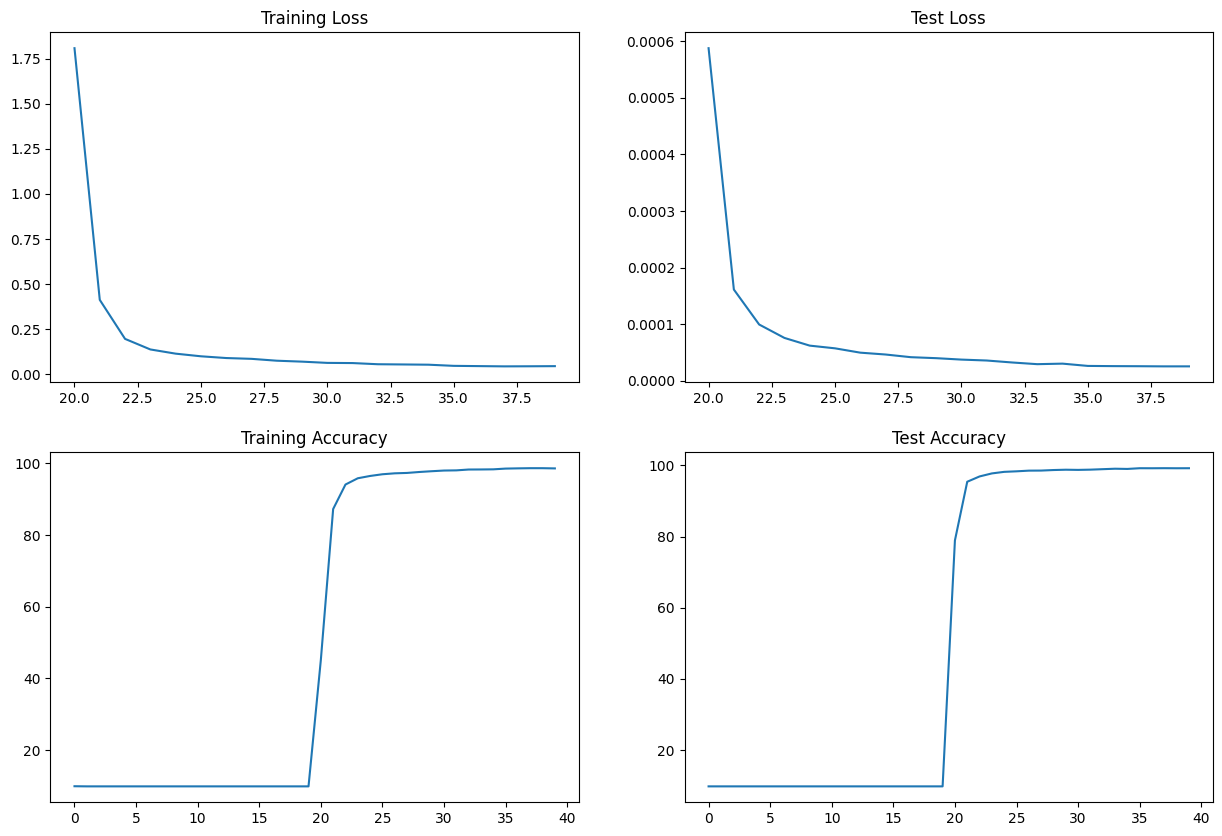

In [27]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [28]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------
